<a href="https://colab.research.google.com/github/Rama389/AI-Projects/blob/main/Supervisied_Learning_decision__tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROBLEM 5: Parameter Sweep on Decision Trees

**Brief Summary**:

1. Parameter sweep is a decision tree algorithm.
2. It uses hyperparameters for execution of data for best accuracies
3. Hyper parameters includes depth, Min leaf sample, impurity
4. Sweep algorithm works on the combination of depth and sample leaf
5. Decision tree algorithm is applied for each coimbation/training data
6. Accuracy is evaluated for each coimbation
7. Optimal depth, sample leaf size and accuracy is determined

Loading data from mushrooms.csv...
Original data shape: (8124, 23)
Dropping column 'feature_11' due to missing values ('?').
Applying One-Hot Encoding to features...
Encoded features shape: (8124, 91)
Mapped target shape: (8124,)
Train data shape: (5686, 91)
Test data shape: (2438, 91)

--- Starting Decision Tree Parameter Sweep ---
  Testing size (max_depth) = 10, purity (min_samples_leaf) = 60...
    Train Acc: 0.9924, Test Acc: 0.9914
  Testing size (max_depth) = 10, purity (min_samples_leaf) = 65...
    Train Acc: 0.9924, Test Acc: 0.9914
  Testing size (max_depth) = 10, purity (min_samples_leaf) = 70...
    Train Acc: 0.9879, Test Acc: 0.9856
  Testing size (max_depth) = 10, purity (min_samples_leaf) = 75...
    Train Acc: 0.9879, Test Acc: 0.9856
  Testing size (max_depth) = 10, purity (min_samples_leaf) = 80...
    Train Acc: 0.9879, Test Acc: 0.9856
  Testing size (max_depth) = 10, purity (min_samples_leaf) = 85...
    Train Acc: 0.9879, Test Acc: 0.9856
  Testing size (max_dep

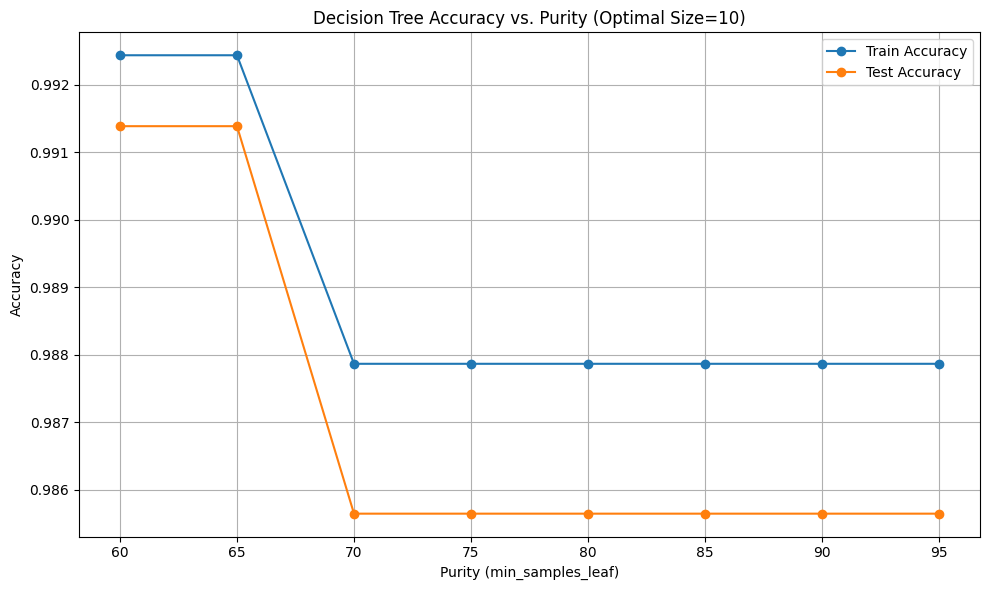


'DT_Purity_vs_Accuracy.png' generated successfully.


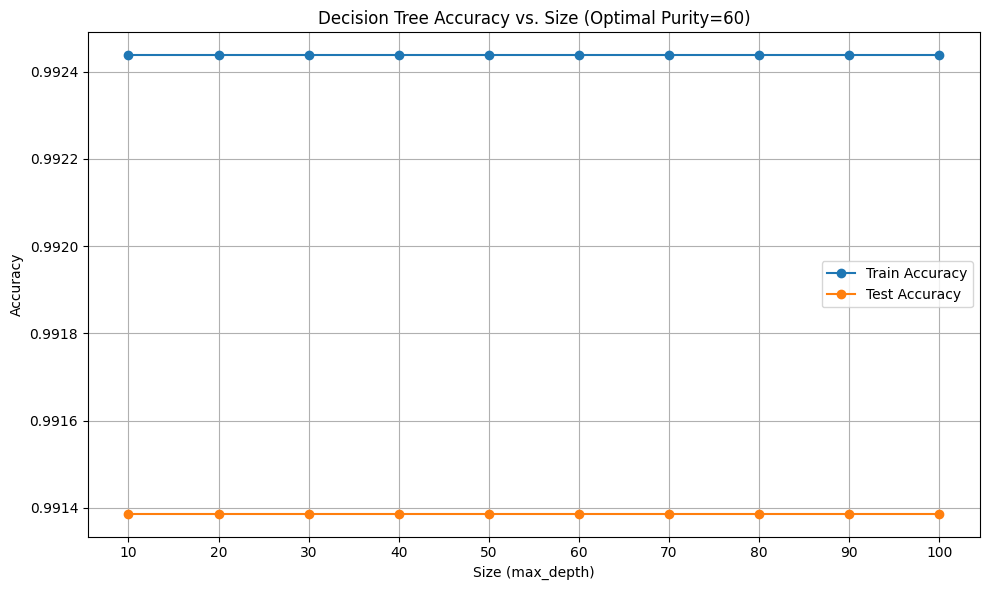


'DT_Size_vs_Accuracy.png' generated successfully.

--- Decision Tree Sweep Completed ---
Check 'tree_sweep.csv', 'optimal_tree_rules.txt', 'DT_Purity_vs_Accuracy.png', and 'DT_Size_vs_Accuracy.png' in your directory.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import itertools # For generating combinations of parameters

# --- Configuration ---
DATA_FILE = 'mushrooms.csv'
TEST_SIZE = 0.3        # 30% for testing, 70% for training
RANDOM_STATE = 42      # For reproducibility of data split

# Parameters for the sweep
TREE_SIZES = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # Interpreted as max_depth
PURITY_THRESHOLDS = [60, 65, 70, 75, 80, 85, 90, 95] # Interpreted as min_samples_leaf (absolute count)

# --- 1. Data Loading and Preprocessing ---
print(f"Loading data from {DATA_FILE}...")
try:
    # Load the dataset, skipping the header row and assuming first column is target
    data = pd.read_csv(DATA_FILE, header=None, skiprows=1)
except FileNotFoundError:
    print(f"Error: The file '{DATA_FILE}' was not found. Please ensure it's in the same directory.")
    exit()

# Assign column names for better readability (based on common mushrooms.csv structure)
# This is a simplified list; a full list of mushroom attributes would be longer.
# For this example, we'll just use generic names for features.
# The first column is 'class'
data.columns = ['class'] + [f'feature_{i}' for i in range(1, data.shape[1])]

print(f"Original data shape: {data.shape}")

# Separate target variable (y) and features (X)
y = data['class']
X = data.drop('class', axis=1)

# --- Handle Missing Values ---
# The 'stalk-root' feature (often feature_11 or similar) commonly has '?' values.
# For simplicity, we'll drop any columns that contain '?'
cols_to_drop = []
for col in X.columns:
    if (X[col] == '?').any():
        cols_to_drop.append(col)
        print(f"Dropping column '{col}' due to missing values ('?').")
X = X.drop(columns=cols_to_drop)

# --- One-Hot Encode Categorical Features ---
# All remaining features are categorical, so apply one-hot encoding
print("Applying One-Hot Encoding to features...")
X_encoded = pd.get_dummies(X, drop_first=True) # drop_first avoids multicollinearity

# Map target labels to numerical values ('e' -> 0, 'p' -> 1)
# This is crucial for sklearn's classifiers
y_mapped = y.map({'e': 0, 'p': 1})
if y_mapped.isnull().any():
    print("Warning: Non-'e'/'p' labels found in target column. Please check your data.")
    # Handle other labels if necessary, for now, just map 'e' and 'p'

print(f"Encoded features shape: {X_encoded.shape}")
print(f"Mapped target shape: {y_mapped.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_mapped, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_mapped
)

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# --- 2. tree_sweep function definition ---

def tree_sweep(train, test, size=TREE_SIZES, purity=PURITY_THRESHOLDS):
    """
    Performs a parameter sweep for Decision Tree classifier across size (max_depth)
    and purity (min_samples_leaf) thresholds.

    Args:
        train (tuple): A tuple (X_train, y_train) for training data.
        test (tuple): A tuple (X_test, y_test) for test data.
        size (list): List of max_depth values to sweep.
        purity (list): List of min_samples_leaf values to sweep.

    Returns:
        pd.DataFrame: DataFrame containing sweep results (size, purity, train_accuracy, test_accuracy).
    """
    X_train, y_train = train
    X_test, y_test = test

    print("\n--- Starting Decision Tree Parameter Sweep ---")
    results = []
    best_test_accuracy = -1
    optimal_params = {}
    optimal_tree_model = None

    # Iterate through all combinations of size (max_depth) and purity (min_samples_leaf)
    for s_val, p_val in itertools.product(size, purity):
        print(f"  Testing size (max_depth) = {s_val}, purity (min_samples_leaf) = {p_val}...")

        # Initialize Decision Tree Classifier with Information Gain (entropy)
        # and current parameter values
        dt_classifier = DecisionTreeClassifier(
            criterion='entropy',
            max_depth=s_val,
            min_samples_leaf=p_val,
            random_state=RANDOM_STATE # For reproducibility of tree building process
        )

        # Fit the model on the training data
        dt_classifier.fit(X_train, y_train)

        # Calculate training accuracy
        y_train_pred = dt_classifier.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)

        # Calculate test accuracy
        y_test_pred = dt_classifier.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        results.append({
            'size': s_val,
            'purity': p_val,
            'training-accuracy': train_accuracy,
            'test-accuracy': test_accuracy
        })
        print(f"    Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

        # Check for the optimal tree based on highest test accuracy
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            optimal_params = {'size': s_val, 'purity': p_val}
            optimal_tree_model = dt_classifier # Store the best model

    df_results = pd.DataFrame(results)
    df_results.to_csv('tree_sweep.csv', index=False)
    print("\ntree_sweep.csv generated successfully.")

    print(f"\nOptimal Tree Found:")
    print(f"  Size (max_depth): {optimal_params['size']}")
    print(f"  Purity (min_samples_leaf): {optimal_params['purity']}")
    print(f"  Highest Test Accuracy: {best_test_accuracy:.4f}")

    # Generate Rules from the Optimal Tree
    print("\n--- Rules from the Optimal Tree ---")
    # Feature names for readability in rules
    feature_names = X_encoded.columns.tolist()
    # Class names for readability (mapped back from 0, 1 to 'e', 'p')
    class_names = ['edible', 'poisonous'] # Assuming 0->'e', 1->'p'

    # Export text representation of the tree rules
    tree_rules = export_text(optimal_tree_model, feature_names=feature_names, class_names=class_names)
    print(tree_rules)

    # Save rules to a file
    with open('optimal_tree_rules.txt', 'w') as f:
        f.write(f"Optimal Tree Parameters: max_depth={optimal_params['size']}, min_samples_leaf={optimal_params['purity']}\n")
        f.write(f"Test Accuracy: {best_test_accuracy:.4f}\n\n")
        f.write(tree_rules)
    print("\nOptimal tree rules saved to 'optimal_tree_rules.txt'.")


    # --- Plotting ---
    # For the optimal value of size, plot purity vs. train/test accuracy curves
    optimal_size_df = df_results[df_results['size'] == optimal_params['size']].sort_values(by='purity')
    plt.figure(figsize=(10, 6))
    plt.plot(optimal_size_df['purity'], optimal_size_df['training-accuracy'], marker='o', label='Train Accuracy')
    plt.plot(optimal_size_df['purity'], optimal_size_df['test-accuracy'], marker='o', label='Test Accuracy')
    plt.title(f'Decision Tree Accuracy vs. Purity (Optimal Size={optimal_params["size"]})')
    plt.xlabel('Purity (min_samples_leaf)')
    plt.ylabel('Accuracy')
    plt.xticks(PURITY_THRESHOLDS)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('DT_Purity_vs_Accuracy.png')
    plt.show()
    print("\n'DT_Purity_vs_Accuracy.png' generated successfully.")

    # For the optimal value of purity, plot size vs. train/test accuracy curves
    optimal_purity_df = df_results[df_results['purity'] == optimal_params['purity']].sort_values(by='size')
    plt.figure(figsize=(10, 6))
    plt.plot(optimal_purity_df['size'], optimal_purity_df['training-accuracy'], marker='o', label='Train Accuracy')
    plt.plot(optimal_purity_df['size'], optimal_purity_df['test-accuracy'], marker='o', label='Test Accuracy')
    plt.title(f'Decision Tree Accuracy vs. Size (Optimal Purity={optimal_params["purity"]})')
    plt.xlabel('Size (max_depth)')
    plt.ylabel('Accuracy')
    plt.xticks(TREE_SIZES)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('DT_Size_vs_Accuracy.png')
    plt.show()
    print("\n'DT_Size_vs_Accuracy.png' generated successfully.")

    return df_results

# --- Main Execution ---

# Prepare data for the tree_sweep function as tuples (X, y)
train_data_tuple = (X_train, y_train)
test_data_tuple = (X_test, y_test)

# Perform the decision tree sweep
sweep_results_df = tree_sweep(
    train_data_tuple,
    test_data_tuple,
    size=TREE_SIZES,
    purity=PURITY_THRESHOLDS
)

print("\n--- Decision Tree Sweep Completed ---")
print("Check 'tree_sweep.csv', 'optimal_tree_rules.txt', 'DT_Purity_vs_Accuracy.png', and 'DT_Size_vs_Accuracy.png' in your directory.")

**Comment**: With Optimal depth-10 and the leaf sample-60 the highest accuracy is acheived that is 99.14%.

If the depth is too much then computational expenses will increase and also the problem of overfitting occurs.

If depth is very less then purity will be less and accuracy level will be low